   #  MP307 Practical 2 Queueing Theory II

## Python functions

The Python functions contained in this notebook are:

1. `Nearneigh(pup,pdown,r)`. This generates the transition matrix `P` for a simple nearest neighbour model with maximum size `r` and probability `pup` of one step up transition and  `pdown` for one step down transition. The output is the transition matrix.

2. `Equilibrium(P)`. This computes the equilibrium probabilities for a given transition matrix `P`. If the system is not ergodic then an error message appears. The output is an array.

3. `Queue(P,n0,nit)`. This simulates a queue for a given transition matrix `P` with initial queue size `n0` for `nit`  iterations. The output is a list of simulated queue data.

4. `Qplot(qdata,pi)`. This generates an animation of the queue for any input data list `qdata`. The second argument is optional and consists of the equilibrium probabilities `pi` (if they exist and have been calculated via `Equilibrium(P)` above or otherwise). The output is a Python animation where 50 plots are shown for the normalised frequency of events which can be compared to a plot of the equilibrium probabilities `pi` if provided. 

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import random as ran

In [2]:
def Nearneigh (pup, pdown, r):
    # This generates the transition matrix P for a nearest neighbour model with 
    # maximum size r and probability pup of one step up transition and pdown 
    # for one step down transition. 
    # The output is the transition matrix P.
    P = np.zeros((r + 1, r + 1))
    P[0, 0] = 1 - pup
    P[0, 1] = pup
    P[r , r ] = 1 - pdown
    P[r , r - 1] = pdown
    for i in range(1, r):
        P[i, i - 1] = pdown
        P[i , i] = 1 - pdown - pup
        P[i , i + 1] = pup
    return(P)


## Example. 
Find the transition matrix for a queue of maximum size 5 with prob customer arrival=0.2 and prob customer servicing=0.3

In [4]:
P=Nearneigh(0.2,0.3,5)
print(P)

[[0.8 0.2 0.  0.  0.  0. ]
 [0.3 0.5 0.2 0.  0.  0. ]
 [0.  0.3 0.5 0.2 0.  0. ]
 [0.  0.  0.3 0.5 0.2 0. ]
 [0.  0.  0.  0.3 0.5 0.2]
 [0.  0.  0.  0.  0.3 0.7]]


In [19]:
def Equilibrium (P):
    # This computes the equilibrium probabilities pi for a given transition matrix P. 
    # If the system is not ergodic then an error message appears. 
    # The output is an array.
    degenflag = 0
    n = len(P)
    pi = np.zeros((n))
    for i in range(n):
        if float(sum(P[i,:]))!= 1.0:
            print("ERROR: row",i,"of P does not sum to 1 !")
    eigenvals, eigenvects=np.linalg.eig(P.transpose()) # eigendata for P transpose
    for k in range(n):
        if abs(eigenvals[k]-1)< 1.0e-14:
            degenflag = degenflag + 1
            k1=k # label for eigenvalue 1.
    if 1 < degenflag:
        print("ERROR: P is not Ergodic")
    else:
        v=eigenvects[:,k1]
        pi=v/sum(v)
    return(pi.real)

In [20]:
pi=Equilibrium(P)
print(pi)

[0.36541353 0.24360902 0.16240602 0.10827068 0.07218045 0.0481203 ]


In [21]:
def Queue (P, n0, nit):
# This simulates a queue for a given transition matrix P with initial queue size n0 for nit iterations. 
# The output is a list of simulated queue data.
    nP = len(P)
# pp is a relabelled transition matrix with row elements in decreasing order.
# This is used to speed up the simulation process
# The relabelling is stored in the matrix loc.
    pp = np.zeros((nP,nP))
    for i in range(nP):
        for j in range(nP):
            pp[i, j] = P[i, j]
    loc = np.array([list(range(nP))]*nP)
    for i in range(nP):
        for j in range(nP-1):
            maxpp = pp[i, j]
            kmax = j
            for k in range(j, nP):
                if maxpp < pp[i, k]:
                    maxpp = pp[i, k]
                    kmax = k
                    pp[i, j], pp[i, k] = pp[i, k], pp[i, j]
                    loc[i, j], loc[i, k] = loc[i, k], loc[i, j]
    n = n0
    qseq = [n0]
    if n0 < 0 or nP-1 < n0:
        print("ERROR: inputted initial Q size : Qsize<0 or Qsize>",nP-1)
    for m in range(nit):
        x = ran.random() # generates uniform random no on [0,1] 
        k = 0
        x1 = pp[n, k]
        while (x1 < x):
            k = k + 1
            x1 = x1 + pp[n, k]
        n = loc[n, k] 
        qseq = qseq + [n]
    return(qseq)

In [22]:
print(P) # For the transition matrix in our example above

[[0.8 0.2 0.  0.  0.  0. ]
 [0.3 0.5 0.2 0.  0.  0. ]
 [0.  0.3 0.5 0.2 0.  0. ]
 [0.  0.  0.3 0.5 0.2 0. ]
 [0.  0.  0.  0.3 0.5 0.2]
 [0.  0.  0.  0.  0.3 0.7]]


### Simulate 1000 steps with intial state 2 for given P

In [23]:
qdata=Queue(P,2,1000) 

In [24]:
len(qdata) # notice there are 1001 data pts for 1000 steps

1001

In [25]:
def Qplot(qdata,pi=0):
    # This generates up to 50 animations of the queue for any input data list qdata
    # The second argument is optional and consists of the equilibrium probabilities pi 
    # (if they exist and have been calculated via Equilibrium(P) above). 
    # The output is an animation of 50 plots of the normalised frequency of events.
    # This is compared to the equilibrium probabilities pi if provided.
    
    # Nsim animations
    Nsim=50
    
    Npoints=len(qdata)
    qmax=max(qdata)
    
    shift = lambda x: x-1/2    
    inbins=list(map(shift,list(range(qmax+2)))) # bins -1/2,1/2,3/2,...
    n,bins  = np.histogram(qdata, bins=inbins)
    
    freq=np.array(n)/Npoints 
                          
    # get the corners of the rectangles for the histogram
        
    left = bins[:-1]
    right = bins[1:]  
    bottom = np.zeros(len(left))
    top = bottom + freq
    nrects = len(left)

    # Here comes the tricky part -- we have to set up the vertex and path codes
    # arrays using `.Path.MOVETO`, `.Path.LINETO` and `.Path.CLOSEPOLY` for each rect.

    #* We need 1 ``MOVETO`` per rectangle, which sets the initial point.
    #* We need 3 ``LINETO``'s, which tell Matplotlib to draw lines from
    #  vertex 1 to vertex 2, v2 to v3, and v3 to v4.
    #* We then need one ``CLOSEPOLY`` which tells Matplotlib to draw a line from
    #  the v4 to our initial vertex (the ``MOVETO`` vertex), in order to close the
    #  polygon.

    #<div class="alert alert-info"><h4>Note</h4><p>The vertex for ``CLOSEPOLY`` is ignored, but we still need a placeholder
    #  in the ``verts`` array to keep the codes aligned with the vertices.</p></div>

    nverts = nrects * (1 + 3 + 1)
    verts = np.zeros((nverts, 2))
    codes = np.full(nverts, path.Path.LINETO)
    codes[0::5] = path.Path.MOVETO
    codes[4::5] = path.Path.CLOSEPOLY
    verts[0::5, 0] = left
    verts[0::5, 1] = bottom
    verts[1::5, 0] = left
    verts[1::5, 1] = top
    verts[2::5, 0] = right
    verts[2::5, 1] = top
    verts[3::5, 0] = right
    verts[3::5, 1] = bottom

    #To animate the histogram, we use the ``qanimate`` function, which updates the locations of the vertices for the
    #histogram (in this case, only the heights of each rectangle). 

    def qanimate(i):
        # simulate data 
        Ni_points=int(Npoints*i/Nsim)
        datai=qdata[1:Ni_points] # first Ni_points 
        ni, bin = np.histogram(datai, bins=inbins)
        freq=np.array(ni)/Ni_points 
        top = bottom + freq
        verts[1::5, 1] = top
        verts[2::5, 1] = top
        time_text.set_text('Time =' +str(Ni_points))

    #``patch`` will eventually be a `.Patch` object.

    patch = None

    fig, ax = plt.subplots()
    barpath = path.Path(verts, codes)
    patch = patches.PathPatch(
        barpath, facecolor='red', edgecolor='black', alpha=1)
    ax.add_patch(patch)
    
    time_text = ax.text(0.4, 0.9, '', transform=ax.transAxes)

    # draw rectangle for equilibrium probs pi
    if not type(pi) is int:
        for m in range(len(pi)):
            heightpi=pi[m]
            widthpi=1
            rectpi = Rectangle((m-1/2, 0), widthpi, heightpi, fc='white', ec ='black',lw = 2, alpha=0.5) 
            ax.add_patch(rectpi)

    ax.set_xlim(-1/2, qmax+1/2)
    ymax=max(freq)*1.5
    ax.set_ylim(0, ymax)

    ani = animation.FuncAnimation(fig, qanimate, Nsim+1,repeat=False, blit=True)
    plt.show()
    return ani

In [26]:
print(qdata)

[2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 3, 3, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 2, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 2, 2, 3, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 3, 4, 4, 4, 

<IPython.core.display.Javascript object>


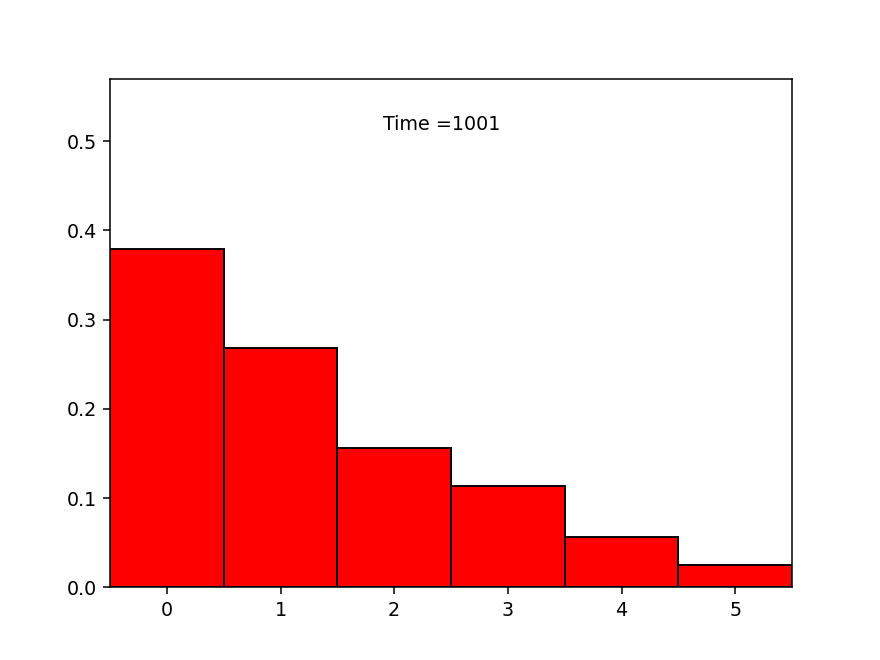

In [27]:
Qplot(qdata) # animation of given qdata without pi given

In [28]:
print(pi)

[0.36541353 0.24360902 0.16240602 0.10827068 0.07218045 0.0481203 ]


<IPython.core.display.Javascript object>


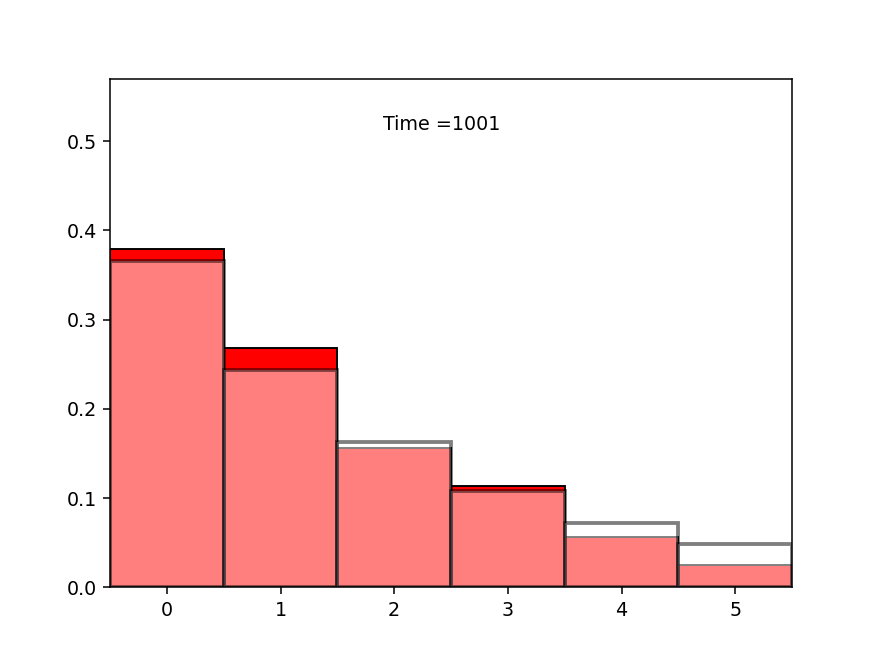

In [29]:
Qplot(qdata,pi) # animation of given qdata with pi given

### Q.1 
Simulate the Markov process with transition matrix: 
$$
\begin{bmatrix} 
1/2 & 0 & 1/2 & 0 & 0 & 0 \\ 
0 & 1/2 & 0 & 1/2 & 0 & 0 \\ 
0 & 0 & 1/2 & 0 & 1/2 & 0 \\ 
0 & 1/4 & 0 & 1/2 & 0 & 1/4 \\ 
1/4 & 0 & 1/4 & 0 & 1/2 & 0 \\ 
0 & 0 & 0 & 1/2 & 0 & 1/2%
\end{bmatrix}
$$

This is the same example as in Q.3 of Practical 1. Observe the long-time behaviour for initial queue size 0 and initial queue size 1. 

Observe what happens if the first row of the transition matrix is changed to $[1/4 , 1/4 , 1/2 , 0 , 0 , 0]$

In [30]:
P=np.array([
    [1/2,0,1/2,0,0,0],
    [0,1/2,0,1/2,0,0],
    [0,0,1/2,0,1/2,0],
    [0,1/4,0,1/2,0,1/4],
    [1/4,0,1/4,0,1/2,0],
    [0,0,0,1/2,0,1/2]
    ])
print(P)

[[0.5  0.   0.5  0.   0.   0.  ]
 [0.   0.5  0.   0.5  0.   0.  ]
 [0.   0.   0.5  0.   0.5  0.  ]
 [0.   0.25 0.   0.5  0.   0.25]
 [0.25 0.   0.25 0.   0.5  0.  ]
 [0.   0.   0.   0.5  0.   0.5 ]]


In [31]:
qdata=Queue(P,0,1000)  # 1000 iterations with initial state 0

In [32]:
print(qdata)

[0, 0, 2, 2, 4, 2, 4, 4, 0, 0, 2, 2, 2, 2, 4, 0, 2, 4, 4, 0, 2, 4, 4, 2, 4, 0, 2, 2, 2, 4, 4, 4, 4, 4, 0, 0, 2, 4, 2, 2, 2, 2, 2, 2, 4, 0, 2, 2, 4, 2, 4, 4, 4, 2, 2, 4, 0, 0, 2, 2, 4, 2, 4, 4, 4, 0, 0, 0, 2, 4, 2, 4, 4, 4, 0, 2, 4, 0, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 0, 0, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 0, 0, 0, 2, 4, 0, 2, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 4, 4, 0, 2, 4, 0, 2, 4, 2, 2, 4, 4, 0, 2, 4, 4, 4, 0, 0, 0, 2, 4, 2, 2, 4, 0, 2, 2, 4, 0, 2, 4, 2, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 0, 2, 2, 4, 0, 0, 0, 0, 0, 2, 2, 4, 4, 0, 0, 2, 2, 4, 4, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 0, 0, 2, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 4, 0, 0, 2, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4, 4, 0, 2, 2, 4, 4, 4, 4, 0, 0, 2, 4, 4, 2, 2, 4, 4, 4, 4, 0, 0, 2, 4, 4, 4, 4, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 

<IPython.core.display.Javascript object>


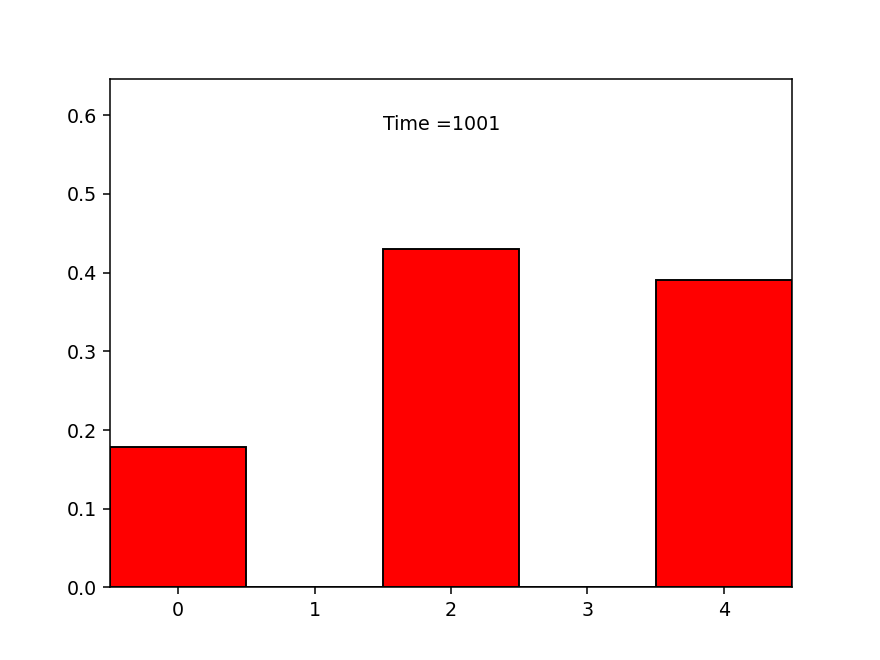

In [33]:
Qplot(qdata)

## Q.2
  A queue is observed over 1000 time intervals where the size of the queue after each time step is given as in Q.4 of Practical 1. 
  Look at that question again for examples of do loops and if else statements in Python

In [34]:
qdata = [4, 5, 6, 6, 6, 7, 6, 7, 6, 5, 4, 4, 5, 6, 7, 6, 5, 4, 3, 4, 5, 6, 5, 4, 3, 2, 1, 2, 3, 2, 1, 
         2, 3, 4, 3, 2, 3, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 3, 4, 5, 4, 5, 6, 7, 
         8, 7, 6, 7, 6, 6, 5, 4, 5, 4, 3, 2, 3, 2, 3, 2, 3, 2, 1, 1, 2, 3, 3, 4, 5, 6, 7, 6, 5, 6, 5, 
         6, 5, 6, 5, 4, 5, 4, 3, 4, 3, 4, 3, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 3, 3, 2, 3, 4, 3, 2, 
         3, 2, 1, 2, 3, 2, 3, 2, 1, 0, 0, 1, 1, 2, 3, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 2, 
         1, 2, 3, 4, 3, 4, 5, 6, 5, 6, 5, 6, 7, 7, 6, 5, 4, 3, 4, 3, 3, 4, 3, 2, 3, 2, 3, 2, 1, 2, 1, 
         2, 1, 0, 0, 0, 0, 1, 2, 3, 2, 2, 3, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 1, 
         0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 2, 3, 2, 3, 3, 4, 5, 6, 5, 4, 3, 2, 1, 2, 
         1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2, 
         1, 0, 0, 1, 2, 3, 2, 3, 2, 2, 3, 4, 4, 5, 4, 3, 2, 3, 2, 3, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 2, 
         1, 0, 1, 0, 1, 2, 3, 3, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 2, 2, 1, 0, 1, 2, 1, 2, 3, 4, 4, 3, 
         2, 2, 1, 2, 3, 4, 5, 4, 4, 5, 4, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 
         1, 2, 2, 3, 2, 3, 4, 5, 6, 5, 6, 5, 4, 5, 6, 7, 6, 5, 6, 6, 7, 6, 7, 7, 6, 7, 6, 5, 4, 5, 5, 
         4, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 5, 5, 4, 3, 4, 5, 6, 5, 4, 3, 3, 4, 3, 2, 3, 2, 3, 3, 2, 1, 
         2, 1, 0, 0, 0, 0, 0, 1, 2, 3, 2, 3, 4, 5, 6, 7, 7, 8, 9, 8, 9, 8, 7, 6, 5, 5, 4, 5, 4, 3, 2, 
         1, 0, 1, 2, 1, 2, 3, 4, 5, 6, 7, 7, 8, 7, 8, 9, 8, 7, 6, 5, 4, 3, 4, 3, 4, 4, 5, 4, 3, 4, 3, 
         2, 3, 2, 3, 3, 2, 1, 1, 0, 1, 2, 1, 2, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 
         3, 2, 1, 0, 0, 1, 2, 3, 4, 3, 2, 3, 2, 2, 1, 0, 1, 0, 0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 6, 7, 7, 
         6, 7, 8, 8, 9, 10, 9, 10, 9, 10, 11, 10, 9, 8, 9, 10, 11, 10, 10, 9, 10, 10, 9, 8, 7, 8, 9, 10,
         9, 8, 7, 6, 7, 6, 7, 6, 5, 4, 4, 5, 4, 3, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0, 
         0, 0, 1, 0, 0, 1, 0, 1, 2, 3, 2, 3, 2, 3, 4, 3, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 3, 2, 
         2, 2, 1, 0, 1, 2, 3, 4, 5, 4, 5, 4, 3, 2, 3, 4, 5, 5, 4, 3, 4, 3, 4, 5, 4, 3, 2, 1, 0, 1, 2, 
         3, 4, 3, 2, 3, 4, 3, 2, 3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 2, 3, 4, 5, 4, 5, 4, 5, 6, 5, 4, 5, 
         6, 5, 4, 3, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 3, 4, 3, 4, 3, 2, 1, 1, 2, 3, 2, 3, 2, 3, 2, 3, 
         4, 3, 4, 4, 5, 6, 7, 6, 7, 7, 6, 5, 4, 3, 4, 3, 2, 2, 3, 4, 3, 4, 3, 2, 1, 0, 0, 1, 2, 3, 2, 
         1, 2, 3, 2, 1, 0, 0, 0, 0, 1, 1, 2, 3, 2, 3, 2, 3, 4, 5, 6, 5, 5, 4, 3, 4, 5, 4, 3, 4, 5, 4, 
         3, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 2, 3, 2, 3, 2, 3, 3, 4, 
         3, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 3, 2, 3, 2, 1, 0, 
         0, 0, 1, 2, 2, 3, 3, 2, 3, 4, 3, 2, 1, 2, 3, 3, 2, 1, 0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 6, 5, 4, 
         5, 4, 5, 4, 3, 2, 3, 4, 3, 2, 1, 2, 3, 4, 3, 2, 3, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 
         0, 1, 2, 2, 3, 2, 1, 0, 1, 2, 3, 4, 4, 3, 4, 3, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 1, 
         0, 0, 1, 0, 1, 2, 2, 3, 3, 4, 3, 2, 3, 2, 1, 0, 0, 1, 2, 1, 2, 3, 2, 1, 2, 3, 2, 3, 2, 1, 0, 
         1, 2, 1, 2, 3, 2, 3, 2, 1, 1, 0]

## Q.3 (*)
### Telephone Exchange Queue.
A telephone exchange consists of $N$
operators on $N$ lines. Assume that the calling and servicing patterns are
Poisson with parameters $\alpha _{k}=\alpha ,\ \beta _{k}=k\beta $
respectively for queue size of $0\leq k\leq N$ and for some $\alpha, \beta >0$.
The equilibrium distribution for the queue is: 
$$
\pi _{k}=\frac{\rho ^{k}}{k!}\left(1+\rho +\frac{\rho ^{2}}{2!}+...+\frac{\rho
^{N}}{N!}\right)^{-1},\ \rho =\ \frac{\alpha }{\beta } 
$$
Of particular interest, in this model, is the frequency with which the
exchange becomes saturated over a long period of time i.e. $\pi_N.$ This
should be a small number for an efficient exchange since it provides a
measurement of the number of calls lost to the system.

   1. A telephone exchange has 5 operators who can handle 40 calls an hour each on average. If calls arrive at the exchange on average every 40 secs, show that there is approximately a 5.5\% chance that the exchange will become saturated after a long time.

   2. Simulate this system over 3 hours with 10 sec time intervals. For what proportion of your simulated events do you find all operators are busy?
   
   3. Compare the results of your simulation to the equilibirum probabilities $\pi_{k}$.

### Hints
Calculate $\alpha,\beta$ based on the information given for the 5 operator exchange. Be consistent with use of time units. In part (2) choose 10 secs as the time interval size and construct a transition matrix $P$ before simulating. 

